# __IBKR API Execution Demo__

## __Intro__

2022.07.16
Evan Fotopoulos

This script takes as input the Pig portfolio and sends orders through the IBKR API to a paper trading account. This code requires ibabi (python extension) and IB Gateway (https://www.interactivebrokers.com/en/trading/ibgateway-stable.php) to be installed and logged into. Data permissions in IBKR are also needed.

#### __IB Gateway will need the following settings to be set:__
Configure > API > Settings:
- "Read-Only API": Uncheck
- "Socket Port": 4001

#### __What does this notebook do?:__ _(Achieved with IB API Call)_

- Read in target Pig Portfolio from excel
- _Retrieve current positions_
- _Download Historical Prices for the last month for all stocks above_
- _Retrieve Account Value_
- Calculate Order List as Target Num Stocks - Current Num Stocks
- _Submit orders for target num stocks currently 2% away from previous close_
    - i.e. sell order will be 1.02 * prev close, buy = 0.98 * prev
- 

#### __Approach Chosen Notes:__
- Position allocation = rounddown(NAV/num positions) _(Have not created any logic around account size/closest matching portfolio for a small account)_
- Orders executed are calculated as (target portfolio) - (current portfolio)

#### __Possible next steps:__
Track portfolio with a small account. Ideas:
1. group similar positions and allocate equally by bucket 
2. use PCA to find subset of stocks that tracks pig rets closely



In [2]:
from threading import Thread
import queue
import datetime
import time

import pandas as pd
import numpy as np
import datetime as dt

from ibapi import wrapper
from ibapi.client import EClient
from ibapi.utils import iswrapper #just for decorator
from ibapi.common import *
from os import path
from ibapi.contract import Contract
from ibapi.order import *

from ibapi import wrapper

from ibapi.wrapper import EWrapper
from ibapi.common import TickerId
from threading import Thread

from ibapi.common import BarData

from numpy import outer


In [3]:
data_path = "C:/Users/User/OneDrive/Documents/temp/materials/3.2InteractiveBrokersAPIDemo/0.Data/"
data_path = "C:/Users/User/OneDrive/Documents/temp/materials/3.2InteractiveBrokersAPIDemo/0.Data/"
output_path = data_path+"Price/"

strat = pd.read_excel(data_path+"Allocation.xlsx")
print(strat.head())

  Ticker Direction     Desc
0    SMH     Short    semis
1    EFA     Short      EFA
2    JNK     Short      JNK
3    XLF     Short    banks
4   EUFN     Short  banks 2


Retrieve current positions

In [4]:
class PositionsApp(EWrapper, EClient):

    def __init__(self):
        EClient.__init__(self, self)

        self.all_positions = pd.DataFrame([], columns = ['Ticker', 'Current Num Shares', 'Sec Type'])

    def error(self, reqId:TickerId, errorCode:int, errorString:str):
        if reqId > -1:
            print("Error. Id: " , reqId, " Code: " , errorCode , " Msg: " , errorString)

    def position(self, account, contract, pos, avgCost):
        index = str(account)+str(contract.symbol)
        self.all_positions.loc[index]= contract.symbol, pos, contract.secType

def run_loop():
    app.run()

app = PositionsApp()
app.connect('127.0.0.1', 4001, 4)
#Start the socket in a thread
api_thread = Thread(target=run_loop, daemon=True)
api_thread.start()
time.sleep(1) #Sleep interval to allow time for connection to server

app.reqPositions() # associated callback: position
print("Waiting for IB's API response for accounts positions requests...\n")
time.sleep(3)
current_positions = app.all_positions
current_positions.set_index('Ticker',inplace=True) 
app.disconnect()

current_positions


Waiting for IB's API response for accounts positions requests...



,Current Num Shares,Sec Type
Ticker,,
SMH,-220.0,STK
AAPL,52.0,STK


In [5]:
pig_allocation = 0.9 # Select a number from 0 to 1 that indicates % of NAV allocated to pig. Any existing positions will be exited
order_list = pd.DataFrame(index = strat["Ticker"])
order_list["Direction"] = strat.set_index("Ticker").loc[order_list.index, 
                                                        "Direction"]
order_list = order_list.join(current_positions, how = "outer")

Next, convert order list to "ticker_list" a dict that will be used in historical data download app

In [6]:
ticker_list = order_list.reset_index()["Ticker"].to_dict()
print(ticker_list)

{0: 'AAPL', 1: 'AMZN', 2: 'BIL', 3: 'BITO', 4: 'DIA', 5: 'EEM', 6: 'EFA', 7: 'EMB', 8: 'EUFN', 9: 'FXF', 10: 'FXY', 11: 'GLD', 12: 'GOOGL', 13: 'HYG', 14: 'IEI', 15: 'IGSB', 16: 'IJH', 17: 'IWM', 18: 'JNK', 19: 'LQD', 20: 'META', 21: 'MSFT', 22: 'NVDA', 23: 'QQQ', 24: 'REM', 25: 'SHV', 26: 'SHY', 27: 'SLV', 28: 'SMH', 29: 'SPY', 30: 'STIP', 31: 'TLT', 32: 'UUP', 33: 'VGK', 34: 'VNQ', 35: 'XLF'}


Create a HistoricalPricesBot and use it to download historical prices for the last month for all stocks on the ticker list above. The most recent closing prices will be used to calculate allocation per stock at a later stage

In [7]:
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
from ibapi.common import BarData

import datetime
from numpy import outer
import pandas as pd

class HistoricalPriceBot(EWrapper, EClient):
    def __init__(self, order_list, output_path):
        EClient.__init__(self, self)
        self.ticker_count = 1
        self.tickers = ticker_list
        self.output_path = output_path
        self.df = pd.DataFrame(columns = ["Ticker","Date","Open","High"
                                          "Low","Close","Volume","Count",
                                          "WAP"])
        self.closes = pd.DataFrame()
        
    def nextValidId(self, orderId:int):
        #4 first message received is this one
        print("setting nextValidOrderId: %d", orderId)
        self.nextValidOrderId = orderId
        #5 start requests here
        first_ticker_key = list(self.tickers.keys())[0]
        self.start(ticker_count = first_ticker_key)

    def historicalData(self, reqId:int, bar: BarData):
        #7 data is received for every bar
        df2 = pd.DataFrame({"Ticker":[ reqId], "Date":[ bar.date], "Open":[ bar.open],"High":[ bar.high], 
                            "Low":[ bar.low], "Close":[ bar.close], "Volume":[ bar.volume],"Count":[ bar.barCount], 
                            "WAP":[ bar.average]}) 

        self.df = self.df.append(df2)
        self.closes.loc[bar.date, reqId] = bar.close
            
    def historicalDataEnd(self, reqId: int, start: str, end: str):
        #8 data is finished
        #9 this is the logical end of your program
        print("finished for: "+str(self.tickers[reqId]))
        reqId += 1
        if reqId in self.tickers:
            self.start(reqId)
        else:
            self.df.replace({"Ticker":self.tickers}).to_csv(self.output_path+self.queryTime.replace(":","")+".csv")
            self.closes.columns =ticker_list.values() #TODO: This is lazy, do better
            self.closes.to_csv(self.output_path+"closes"+self.queryTime.replace(":","")+".csv")
            app.disconnect()
        
    def error(self, reqId, errorCode, errorString):
        # these messages can come anytime.
        print("Error. Id: " , reqId, " Code: " , errorCode , " Msg: " , errorString)

    def start(self, ticker_count):
        self.queryTime = (datetime.datetime.today()).strftime("%Y%m%d %H:%M:%S")

        contract = Contract()
        contract.secType = "STK" 
        contract.symbol = self.tickers[ticker_count]
        contract.currency = "USD"
        contract.exchange = "SMART"
        contract.primaryExchange = 'ISLAND' # Add this to avoid ambiguity for META i.e. without this line
        app.reqHistoricalData(ticker_count, contract, self.queryTime,"1 M", "1 day", "MIDPOINT", 1, 1, False, [])
    
    # def get_closes():
    #     return self.closes

app = HistoricalPriceBot(ticker_list, output_path) #1 create wrapper subclass and pass it to EClient
app.connect("127.0.0.1", 4001, clientId=2) #2 connect to TWS/IBG
app.run() #3 start message thread
closes = app.closes#get_closes()

setting nextValidOrderId: %d 1
Error. Id:  -1  Code:  2104  Msg:  Market data farm connection is OK:usfarm
Error. Id:  -1  Code:  2107  Msg:  HMDS data farm connection is inactive but should be available upon demand.ushmds
Error. Id:  -1  Code:  2158  Msg:  Sec-def data farm connection is OK:secdefil
Error. Id:  -1  Code:  2106  Msg:  HMDS data farm connection is OK:ushmds
finished for: AAPL
finished for: AMZN
finished for: BIL
finished for: BITO
finished for: DIA
finished for: EEM
finished for: EFA
finished for: EMB
finished for: EUFN
finished for: FXF
finished for: FXY
finished for: GLD
finished for: GOOGL
finished for: HYG
finished for: IEI
finished for: IGSB
finished for: IJH
finished for: IWM
finished for: JNK
finished for: LQD
finished for: META
finished for: MSFT
finished for: NVDA
finished for: QQQ
finished for: REM
finished for: SHV
finished for: SHY
finished for: SLV
finished for: SMH
finished for: SPY
finished for: STIP
finished for: TLT
finished for: UUP
finished for: VGK
f

Create an Account Value Bot to retrieve the account value. This feeds into the position size calculation

In [8]:
class AccValueBot(wrapper.EWrapper, EClient):
    def __init__(self):
        wrapper.EWrapper.__init__(self)
        EClient.__init__(self, wrapper=self)

    @iswrapper
    def nextValidId(self, orderId:int):
        # print("setting nextValidOrderId: %d", orderId)
        self.nextValidOrderId = orderId
        self.reqAccountSummary(0,"All","NetLiquidation")
        # self.reqAccountSummary(9002, "All", "$LEDGER") #Use this to get cash balance instead of NAV
        
    @iswrapper
    def accountSummary(self, reqId:int, account:str, tag:str, value:str, currency:str):
        if tag == "NetLiquidation":
            self.account_value = value
        #Uncomment below & $LEDGER call above to get cash balance instead of NAV
        # if tag == "CashBalance":
        #     self.account_value = value

    @iswrapper
    def accountSummaryEnd(self, reqId:int):
        self.disconnect()

app = AccValueBot()
app.connect("127.0.0.1", 4001, clientId=1)
app.run()
account_value = app.account_value
print(account_value)

ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefil


843806.63


Add closing prices to the order list, then calculate the number of shares to trade. This is calculated based on:
- Current Portfolio Nav
- Current Positions
- Pig Allocations

In [10]:

order_list["Price"] = closes.loc[np.max(closes.index), order_list.index]
order_list["Ideal Alloc"] = pig_allocation*float(account_value)/strat["Ticker"].shape[0]
order_list.loc[order_list["Direction"] == "Short",("Ideal Alloc")] *= -1

order_list["Ideal Num Shares"] = np.floor(np.abs(order_list["Ideal Alloc"]).divide(order_list["Price"]))
order_list.loc[order_list["Direction"] == "Short",("Ideal Num Shares")] *= -1

order_list["Exposure"] = order_list["Ideal Num Shares"].multiply(order_list["Price"])
order_list.loc[pd.isnull(order_list["Current Num Shares"]), ("Current Num Shares")] = 0
order_list["To Trade"] = order_list["Ideal Num Shares"].subtract(order_list["Current Num Shares"])
print(order_list.head())

       Direction  Current Num Shares Sec Type    Price  Ideal Alloc  \
Ticker                                                                
AAPL       Short                52.0      STK  150.190 -21095.16575   
AMZN       Short                 0.0      NaN  113.585 -21095.16575   
BIL         Long                 0.0      NaN   91.425  21095.16575   
BITO       Short                 0.0      NaN   13.095 -21095.16575   
DIA        Short                 0.0      NaN  312.685 -21095.16575   

        Ideal Num Shares   Exposure  To Trade  
Ticker                                         
AAPL              -140.0 -21026.600    -192.0  
AMZN              -185.0 -21013.225    -185.0  
BIL                230.0  21027.750     230.0  
BITO             -1610.0 -21082.950   -1610.0  
DIA                -67.0 -20949.895     -67.0  


Perform a quick check of actual allocation to each position (based on previous closing price) versus ideal (exactly equal weight). This is important, because a small account may struggle to track a portfolio with so many positions closely

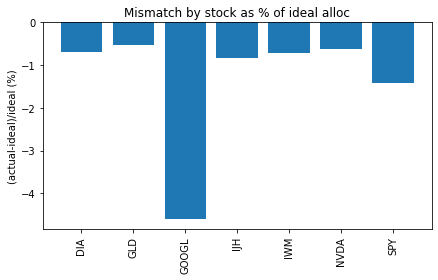

In [13]:
#Plot of how far off the mark we are as % of ideal allocation

import matplotlib.pyplot as plt
order_list["mismatch (%)"] = order_list["Exposure"].subtract(order_list["Ideal Alloc"]).div(order_list["Ideal Alloc"]).multiply(100)
to_plot = order_list[np.abs(order_list["mismatch (%)"]) > 0.5]
plt.bar(to_plot.index, to_plot["mismatch (%)"])
plt.title("Mismatch by stock as % of ideal alloc")
plt.xticks(rotation=90)
plt.tight_layout()
plt.ylabel("(actual-ideal)/ideal (%)")
plt.show()

Not too bad given the dummy account is big.

The next step is to create an OrderBot to enter all the trades calculated above.
The order bot has a default limit order set at 2% off the previous close i.e. if we want to short a share that closed at 100 yesterday, the bot will enter a sell limit order at 102

In [15]:
#Class for OrderBot
class OrderBot(EWrapper, EClient):
    def __init__(self, order_list):
        EClient.__init__(self, self)
        self.order_list = order_list
        self.open_orders = pd.DataFrame([], columns = ['Ticker','Action','orderType',
                                                       'TotalQuantity','Status', 'Filled', 
                                                       'Remaining','LastFillPrice'])
        self.errors = []
        
    def error(self, reqId, errorCode, errorString):
        print("Error: ", reqId, " ", errorCode, " ", errorString)
        errormsg = "IB error id %d errorcode %d string %s" % (reqId, 
                                                              errorCode, 
                                                              errorString)
        self.errors.append(errormsg)

    def openOrder(self, orderId, contract, order, orderState):
        self.open_orders.loc[orderId,("Ticker","Action",
                                      "orderType","TotalQuantity",
                                      "Status")] = [contract.symbol, order.action, 
                                                    order.orderType, order.totalQuantity, 
                                                    orderState.status]

    def orderStatus(self, orderId, status, filled, remaining, avgFillPrice, permId, parentId, lastFillPrice, clientId,
                    whyHeld, mktCapPrice):
        self.open_orders.loc[orderId,("Status", "Filled", 
                                      "Remaining", "LastFillPrice")] = [status, filled, 
                                                                        remaining, lastFillPrice]
        if (orderId == self.nextOrderId - 1):
            self.stop()
            
    def nextValidId(self, orderId):
        self.nextOrderId = orderId
        self.start()

    # def execDetails(self, reqId, contract, execution):
    #     print('Order Executed: ', reqId, contract.symbol, contract.secType, contract.currency, execution.execId,
    #           execution.orderId, execution.shares, execution.lastLiquidity)

    def place_new_IB_order(self, ibcontract, order, orderid=None):
            """
            Places an order
            Returns brokerorderid
            """
            #TODO: Get next orderId from IB
            print("Using order id of %d" % orderid)
            # Place the order
            app.placeOrder(
                orderid,  # orderId,
                ibcontract,  # contract,
                order  # order
            )
            
    def start(self):
        for k in range(len(self.order_list)):
            orderDetails = self.order_list.iloc[k]
            ## Create contract
            contract = Contract()
            contract.symbol = orderDetails.name
            if pd.isnull(orderDetails["Sec Type"]):
                contract.secType = 'STK'                
            else:
                contract.secType = orderDetails["Sec Type"]
            contract.exchange = 'SMART'
            contract.currency = "USD"
            contract.primaryExchange = "ISLAND"
            ## Create order
            order = Order()
            quantity = orderDetails["To Trade"]
            order.orderType =  "LMT"
            order.totalQuantity = np.abs(quantity)
            if np.sign(quantity) > 0:
                order.action = "Buy"
                order.lmtPrice = np.floor(orderDetails["Price"]*0.98)
            elif np.sign(quantity) < 0:
                order.action = "Sell"
                order.lmtPrice = np.ceil(orderDetails["Price"]*1.02)
            #Place order & increment nextOrderId                   
            ## Note: Orderids submitted out of sequence will break IB
            self.place_new_IB_order(contract,order, orderid = self.nextOrderId)
            self.nextOrderId += 1
    
    def stop(self):
        self.disconnect()

app = OrderBot(order_list)
app.connect('127.0.0.1', 4001, 123)
app.run()
app.open_orders

Using order id of 74
Using order id of 75
Using order id of 76
Using order id of 77
Using order id of 78
Using order id of 79
Using order id of 80
Using order id of 81
Using order id of 82
Using order id of 83
Using order id of 84
Using order id of 85
Using order id of 86
Using order id of 87
Using order id of 88
Using order id of 89
Using order id of 90
Using order id of 91
Using order id of 92
Using order id of 93
Using order id of 94
Using order id of 95
Using order id of 96
Using order id of 97
Using order id of 98
Using order id of 99
Using order id of 100
Using order id of 101
Using order id of 102
Using order id of 103
Using order id of 104
Using order id of 105
Using order id of 106
Using order id of 107
Using order id of 108
Using order id of 109
Error:  -1   2104   Market data farm connection is OK:usfarm
Error:  -1   2107   HMDS data farm connection is inactive but should be available upon demand.ushmds
Error:  -1   2158   Sec-def data farm connection is OK:secdefil
Error:  

,Ticker,Action,orderType,TotalQuantity,Status,Filled,Remaining,LastFillPrice
74,AAPL,SELL,LMT,192.0,PreSubmitted,0.0,192.0,0.0
75,AMZN,SELL,LMT,185.0,PreSubmitted,0.0,185.0,0.0
76,BIL,BUY,LMT,230.0,PreSubmitted,0.0,230.0,0.0
77,BITO,SELL,LMT,1610.0,Inactive,0.0,1610.0,0.0
102,SMH,BUY,LMT,122.0,PreSubmitted,0.0,122.0,0.0
80,EFA,SELL,LMT,343.0,PreSubmitted,0.0,343.0,0.0
78,DIA,SELL,LMT,67.0,PreSubmitted,0.0,67.0,0.0
79,EEM,SELL,LMT,545.0,PreSubmitted,0.0,545.0,0.0
81,EMB,SELL,LMT,255.0,PreSubmitted,0.0,255.0,0.0
82,EUFN,SELL,LMT,1431.0,PreSubmitted,0.0,1431.0,0.0


The list above indicates all open orders retrieved from the IBAPI, after new orders were entered. I've checked the portal and can confirm these orders are present.

To summarise:
- Pig allocations retrieved from WifeyAlpha twitter
- Account Value, Current Positions, Closing Prices for a dummy account retrieved from IB API
- Orders calculated that would get IB account from current positions to Pig Portfolio positions
- Orders in the table above executed using IB API 